## Welcome to the Tensorflow Mobilenet transfer learning workshop!
### Here we are going to learn how to take a pretrained Mobilenet V2 from Keras and use transfer learning to apply it to a new dataset.

In [1]:
!pip install tqdm
!pip install sagemaker-experiments

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
%pylab inline
import boto3, re, os
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tensorflow import TensorFlow
from smexperiments.experiment import Experiment
from smexperiments.tracker import Tracker
from smexperiments.trial import Trial
import tarfile
import tensorflow as tf
from glob import glob
import numpy as np
import subprocess
from tqdm import tqdm
import cv2

role = get_execution_role()
sess = sagemaker.Session()
bucket = sess.default_bucket()
sage = boto3.client('sagemaker')

Populating the interactive namespace from numpy and matplotlib


Let's first download the data, we are going to be working with the Caltech256 dataset

In [ ]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar .
!tar -xvf 256_ObjectCategories.tar 

Unfortunately, if we want to use multiple GPUs in Keras, currently we cannot simply access images from a directory, we instead need our images to be in the format of a Numpy array. 

In [6]:
categories = {}
folders = os.listdir('256_ObjectCategories/')
folders.sort()
for d in folders:
    files = glob(f'256_ObjectCategories/{d}/*.jpg')
    files.sort()
    categories[d] = files
    
# since there are not the same amount of images for each category we are going to want to even them out.
ls = []
for cat in categories:
    l = len(categories[cat])
    ls.append(l)
    
examples = min(ls)
ex_ind = np.argmin(ls)
print(f'Minimum number of examples is {examples}')

Minimum number of examples is 80


We will load our images using OpenCV, these specific images are in RBG format, so in order to 

In [25]:
imgs = []
labs = []

for j,cat in tqdm(enumerate(categories)):
    for i,file in enumerate(categories[cat]):
        img = cv2.imread(file)
        img = cv2.resize(img, (224,224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(np.array(img))
        labs.append(j)

img_arr = np.array(imgs) # , dtype=np.float32
labels = tf.keras.utils.to_categorical(labs)
del imgs, labs

257it [00:57,  4.46it/s]


Let's take a look at one of the images

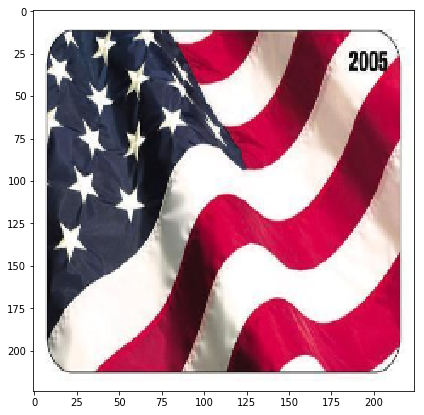

In [26]:
plt.figure(figsize=(14,7))
plt.imshow(img_arr[98])

Let's split our data into train and test sets

In [8]:
split = .8
inds = np.arange(img_arr.shape[0])
np.random.shuffle(inds)
train_x = img_arr[:(int(inds.shape[0]*split))]
train_y = labels[:(int(inds.shape[0]*split))]
test_x = img_arr[(int(inds.shape[0]*split)):]
test_y = labels[(int(inds.shape[0]*split)):]

Now we need to save our data and move it to s3 so that your model can access it.

In [168]:
!mkdir data

np.save('data/train_data.npy',train_x)
np.save('data/train_labels.npy',train_y)
np.save('data/eval_data.npy',test_x)
np.save('data/eval_labels.npy',test_y)


mkdir: cannot create directory ‘data’: File exists


For simplicity we can just download the data from this s3 bucket:

In [8]:
!mkdir data

!wget https://caltech256-bucket.s3.amazonaws.com/train_data.npy -P data
!wget https://caltech256-bucket.s3.amazonaws.com/eval_data.npy -P data
!wget https://caltech256-bucket.s3.amazonaws.com/train_labels.npy -P data
!wget https://caltech256-bucket.s3.amazonaws.com/eval_labels.npy -P data

wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
--2020-05-06 13:05:41--  https://caltech256-bucket.s3.amazonaws.com/train_data.npy
Resolving caltech256-bucket.s3.amazonaws.com (caltech256-bucket.s3.amazonaws.com)... 52.216.129.99
Connecting to caltech256-bucket.s3.amazonaws.com (caltech256-bucket.s3.amazonaws.com)|52.216.129.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3685678208 (3.4G) [application/x-www-form-urlencoded]
Saving to: ‘train_data.npy’

train_data.npy      100%[===================>]   3.43G  71.2MB/s    in 54s     

2020-05-06 13:06:36 (64.9 MB/s) - ‘train_data.npy’ saved [3685678208/3685678208]

--2020-05-06 13:06:36--  http://data/
Resolving data (data)... failed: No address associated with hostname.
wget: unable to resolve host address ‘data’
FINISHED --2020-05-06 13:06:36--
Total wall clock time: 54s
Downloaded: 1 files, 3.4G in 54s (64.9 MB/s)
--2020-05-06 13:06:36--  https://caltech256-bucket.s3

In [5]:
!aws s3 cp --recursive data s3://$bucket/caltech256

upload: data/eval_labels.npy to s3://sagemaker-us-east-1-209419068016/caltech256/eval_labels.npy
upload: data/train_labels.npy to s3://sagemaker-us-east-1-209419068016/caltech256/train_labels.npy
upload: data/eval_data.npy to s3://sagemaker-us-east-1-209419068016/caltech256/eval_data.npy
upload: data/train_data.npy to s3://sagemaker-us-east-1-209419068016/caltech256/train_data.npy


In [2]:
training_data_uri = f's3://{bucket}/caltech256/'
output_uri = f's3://{bucket}/mobilenet/'

mobile_experiment = Experiment.create(
    experiment_name="mobilenet-tf-caltech256-classification1", 
    description="Finetune mobilenet on caltech256", 
    sagemaker_boto_client=sage)

with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sage) as tracker:
     tracker.log_input(name="caltech-dataset", media_type="s3/uri", value=training_data_uri)

Here we specify our estimator and training script that will get executed on a training instance. We can specify the type of instances and number of instances to run training on when we specify our estimator. Let's take a look at mobile_keras.py.

In [11]:
hyperparameters = {'epochs':4, 'lr':.0001, 'batch_size':512}

for i, script in enumerate(['mobile-keras', 'mobile-keras-addl-layer']):
    trial_name = f"cnn-training-job-{script}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mobile_experiment.experiment_name,
        sagemaker_boto_client=sage,
    )
    cnn_trial.add_trial_component(tracker.trial_component)
    mobile_estimator = TensorFlow(
                          entry_point=f'{script}.py', # this points to the script that will execute training
                          model_dir=output_uri, # where the model will eventually be saved
                         role=role,
                         train_instance_count=1, 
                         train_instance_type='ml.p3.8xlarge',
                         framework_version='2.1',
                         py_version='py3',
                        hyperparameters=hyperparameters,
                          script_mode=True,
                         distributions={'parameter_server': {'enabled': True}},
                        metric_definitions=[
                            {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
                            {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
                            {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
                        ],
    ) #,
    
    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))
    
    mobile_estimator.fit(
        inputs={'training': training_data_uri}, 
        job_name=cnn_training_job_name,
        experiment_config={
            "ExperimentName": mobile_experiment.experiment_name, 
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        }
    )


INFO:sagemaker:Amazon SageMaker Debugger does not currently support Parameter Server distribution
INFO:sagemaker:Creating training-job with name: cnn-training-job-1588775704


2020-05-06 14:35:05 Starting - Starting the training job...
2020-05-06 14:35:07 Starting - Launching requested ML instances......
2020-05-06 14:36:13 Starting - Preparing the instances for training......
2020-05-06 14:37:23 Downloading - Downloading input data.........
2020-05-06 14:39:00 Training - Downloading the training image...
2020-05-06 14:39:21 Training - Training image download completed. Training in progress.2020-05-06 14:39:24,359 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-05-06 14:39:24,832 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_parameter_server_enabled": true
    },
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch_size": 

#015  512/24485 [..............................] - ETA: 29:12 - loss: 5.5491 - accuracy: 0.0059#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1024/24485 [>.............................] - ETA: 14:19 - loss: 5.5492 - accuracy: 0.0029#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1536/24485 [>.............................] - ETA: 9:21 - loss: 5.5491 - accu

#015  512/24485 [..............................] - ETA: 4s - loss: 5.5389 - accuracy: 0.0488#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1024/24485 [>.............................] - ETA: 4s - loss: 5.5384 - accuracy: 0.0488#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1536/24485 [>.............................] - ETA: 4s - loss: 5.5375 - accuracy: 0.0488#010#010#010#010#010

#015  512/24485 [..............................] - ETA: 4s - loss: 5.4658 - accuracy: 0.1816#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1024/24485 [>.............................] - ETA: 3s - loss: 5.4697 - accuracy: 0.1699#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1536/24485 [>.............................] - ETA: 3s - loss: 5.4632 - accuracy: 0.1790#010#010#010#010#010

2020-05-06 14:42:03.149187: W tensorflow/python/util/util.cc:319] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /opt/ml/model/000000001/assets
INFO:tensorflow:Assets written to: /opt/ml/model/000000001/assets
2020-05-06 14:42:13,653 sagemaker-containers INFO     Reporting training SUCCESS

2020-05-06 14:42:23 Uploading - Uploading generated training model
2020-05-06 14:42:23 Completed - Training job completed


Training seconds: 300
Billable seconds: 300


INFO:sagemaker:Amazon SageMaker Debugger does not currently support Parameter Server distribution
INFO:sagemaker:Creating training-job with name: cnn-training-job-1588776170


2020-05-06 14:42:50 Starting - Starting the training job...
2020-05-06 14:42:53 Starting - Launching requested ML instances......
2020-05-06 14:43:59 Starting - Preparing the instances for training......
2020-05-06 14:45:05 Downloading - Downloading input data.........
2020-05-06 14:46:41 Training - Downloading the training image...
2020-05-06 14:47:02 Training - Training image download completed. Training in progress.2020-05-06 14:47:06,239 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-05-06 14:47:06,779 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_parameter_server_enabled": true
    },
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch_size": 

UnexpectedStatusException: Error for Training job cnn-training-job-1588776170: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/usr/bin/python3 mobile-keras-addl-layer.py --batch_size 512 --epochs 4 --lr 0.0001 --model_dir s3://sagemaker-us-east-1-209419068016/mobilenet/"

In [10]:
mobile_estimator = TensorFlow(
                      entry_point=f'{script}.py', # this points to the script that will execute training
                      model_dir=output_uri, # where the model will eventually be saved
                     role=role,
                     train_instance_count=1, 
                     train_instance_type='ml.p3.8xlarge',
                     framework_version='2.1',
                     py_version='py3',
                    hyperparameters=hyperparameters,
                      script_mode=True,
                     distributions={'parameter_server': {'enabled': True}},
                    metric_definitions=[
                        {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
                        {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
                        {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
                    ],
)
mobile_estimator.hyperparameters()

{'epochs': '4',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-209419068016/cnn-training-job-1588774991/source/sourcedir.tar.gz"',
 'sagemaker_program': '"mobile-keras.py"',
 'sagemaker_enable_cloudwatch_metrics': 'false',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"cnn-training-job-1588774991"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_parameter_server_enabled': 'true',
 'model_dir': '"s3://sagemaker-us-east-1-209419068016/mobilenet/"'}

In [16]:
from sagemaker.analytics import ExperimentAnalytics
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=sess, 
    experiment_name=mobile_experiment.experiment_name
)
analytic_table = trial_component_analytics.dataframe()

In [17]:
analytic_table

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,model_dir,sagemaker_container_log_level,sagemaker_enable_cloudwatch_metrics,sagemaker_job_name,sagemaker_parameter_server_enabled,sagemaker_program,sagemaker_region,sagemaker_submit_directory
0,cnn-training-job-1588771189-aws-training-job,Training,arn:aws:sagemaker:us-east-1:209419068016:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/t...,1.0,ml.p3.8xlarge,30.0,"""s3://sagemaker-us-east-1-209419068016/mobilen...",20.0,false,"""cnn-training-job-1588771189""",true,"""mobile-keras-addl-layer.py""","""us-east-1""","""s3://sagemaker-us-east-1-209419068016/cnn-tra..."
1,cnn-training-job-1588770694-aws-training-job,Training,arn:aws:sagemaker:us-east-1:209419068016:train...,763104351884.dkr.ecr.us-east-1.amazonaws.com/t...,1.0,ml.p3.8xlarge,30.0,"""s3://sagemaker-us-east-1-209419068016/mobilen...",20.0,false,"""cnn-training-job-1588770694""",true,"""mobile-keras.py""","""us-east-1""","""s3://sagemaker-us-east-1-209419068016/cnn-tra..."
2,TrialComponent-2020-05-06-131131-qxrw,Preprocessing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=sess, 
    experiment_name=mobile_experiment.experiment_name,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=['test:accuracy'],
    parameter_names=['hidden_channels', 'epochs', 'dropout', 'optimizer']
)
analytic_table = trial_component_analytics.dataframe()

In [ ]:
mobile_estimator.deploy(initial_instance_count=1, instance_type='ml.m5.2xlarge', endpoint_name='mobile-endpoint')

Using already existing model: tensorflow-training-2020-05-05-18-32-58-238


-----